In [1]:
import json
from pathlib import Path
import pandas as pd


In [2]:
RESULTS_DIR = Path("results")

rows = []

for file in RESULTS_DIR.glob("results_*.jsonl"):
    with open(file, "r", encoding="utf-8") as f:
        samples = [json.loads(line) for line in f if line.strip()]

    if not samples:
        continue

    model_name = samples[0]["model"]

    # collect scores
    score_keys = samples[0]["scores"].keys()
    aggregated = {k: [] for k in score_keys}
    timestamps = []

    for s in samples:
        for k, v in s["scores"].items():
            aggregated[k].append(v)
        ts = s.get("timestamp")
        if isinstance(ts, (int, float)):
            timestamps.append(ts)

    # compute metrics
    row = {
        "model": model_name,
        "file": file.name,
        "num_samples": len(samples),
    }

    for k, values in aggregated.items():
        if isinstance(values[0], bool):
            # fatal_error rate
            row[f"{k}_rate"] = sum(values) / len(values)
        else:
            row[f"{k}_mean"] = sum(values) / len(values)

    if len(timestamps) >= 2:
        timestamps.sort()
        gaps = [b - a for a, b in zip(timestamps, timestamps[1:])]
        row["avg_seconds_between_entries"] = sum(gaps) / len(gaps)
    else:
        row["avg_seconds_between_entries"] = None

    rows.append(row)

df = pd.DataFrame(rows)
df

,model,file,num_samples,factual_correctness_mean,completeness_mean,hallucination_mean,clarity_mean,lux_quality_mean,overall_mean,fatal_error_rate,avg_seconds_between_entries
0,google/gemma-3-12b-it,results_google__gemma-3-12b-it.jsonl,3610,2.143767,2.194183,3.257895,3.676731,4.334903,2.753657,0.006094,4.731545
1,gemini-3-flash-preview,results_gemini_3_flash_preview.jsonl,3610,3.829640,3.546814,4.169529,4.452632,4.708310,3.996122,0.008864,3.976829
2,mistralai/Ministral-3-8B-Instruct-2512,results_mistralai__Ministral-3-8B-Instruct-251...,3610,1.819668,2.082825,2.735457,3.129086,3.528809,2.377729,0.032410,3.981471
3,microsoft/phi-4,results_microsoft__phi-4.jsonl,3610,1.949861,1.848476,1.704709,3.811911,4.549030,2.255623,0.157618,4.479137
4,meta-llama/Meta-Llama-3-8B-Instruct,results_meta-llama__Meta-Llama-3-8B-Instruct.j...,3610,1.646260,1.776454,2.917729,2.980609,3.649030,2.261496,0.032133,4.457822


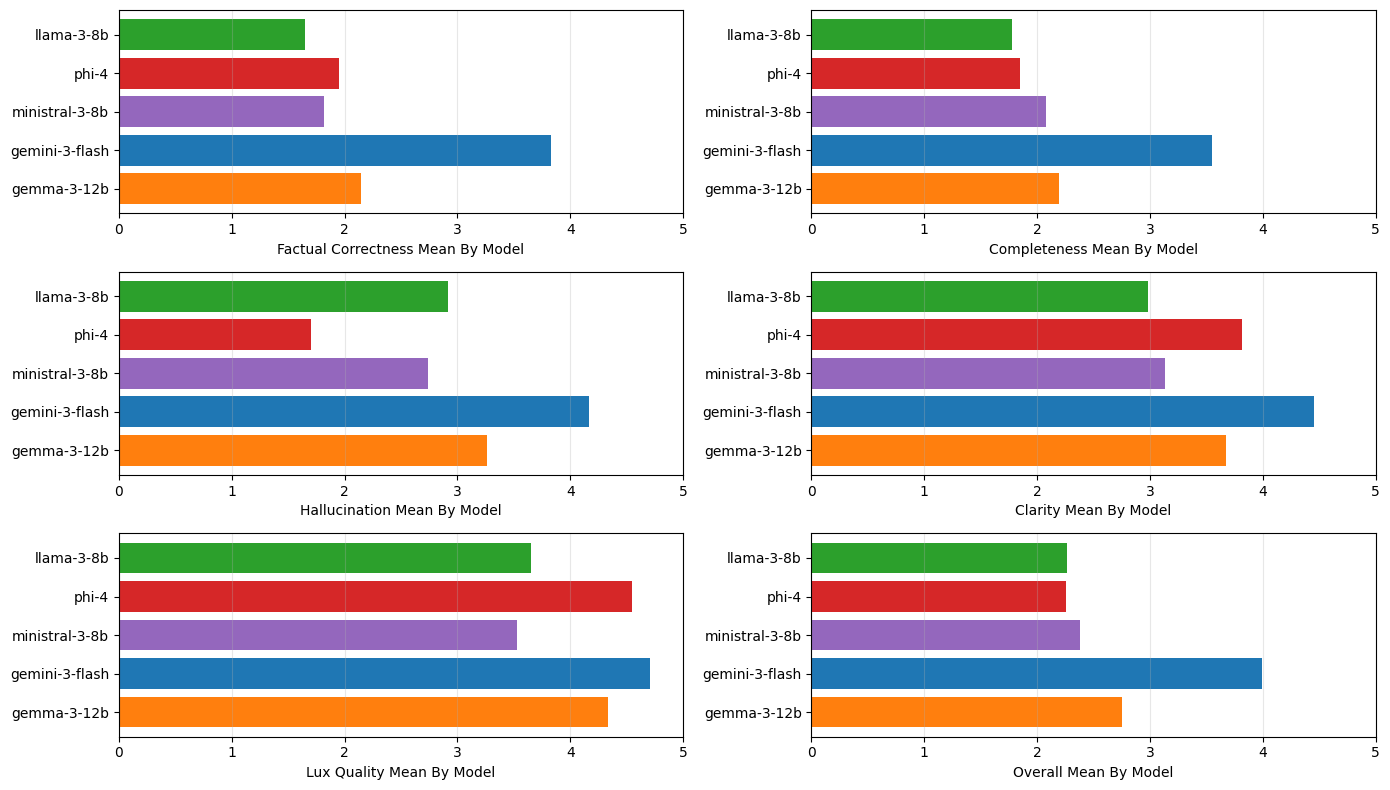

In [3]:
import matplotlib.pyplot as plt

# Get the metric columns (excluding non-metric columns and fatal_error)
metric_columns = [col for col in df.columns if (col.endswith('_mean') or col.endswith('_rate')) and 'fatal_error' not in col]

# Create a mapping of full model names to short names
model_short_names = {
    'meta-llama/Meta-Llama-3-8B-Instruct': 'llama-3-8b',
    'microsoft/phi-4': 'phi-4',
    'mistralai/Ministral-3-8B-Instruct-2512': 'ministral-3-8b',
    'gemini-3-flash-preview': 'gemini-3-flash',
    'google/gemma-3-12b-it': 'gemma-3-12b',
}

# Create a color mapping for models (consistent across all plots)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
model_colors = {}
for i, model in enumerate(sorted(df['model'].unique())):
    short_name = model_short_names.get(model, model)
    model_colors[model] = colors[i % len(colors)]

# Create a figure with subplots for each metric (2 columns, 3 rows)
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each metric
for idx, metric in enumerate(metric_columns):
    # Get colors for each model
    bar_colors = [model_colors[model] for model in df['model']]
    
    # Get short names for models
    short_labels = [model_short_names.get(model, model) for model in df['model']]
    
    axes[idx].barh(short_labels, df[metric], color=bar_colors)
    axes[idx].set_xlabel(metric.replace('_', ' ').title() + ' By Model')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Set x-axis limits: 0 to 5 for score metrics
    if 'rate' in metric:
        axes[idx].set_xlim(0, 1)
    elif 'mean' in metric and 'seconds' not in metric:
        axes[idx].set_xlim(0, 5)

plt.tight_layout()
plt.show()


# Evaluating the Judge

In [4]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr

def calculate_icc(y_true, y_pred):
    """
    Calculates ICC(A,1) - Absolute Agreement.
    This measures if the raters agree on the exact values (1.0 = perfect agreement).
    """
    # Create a matrix (N_samples x 2_raters)
    # y_true = human, y_pred = model
    Y = np.column_stack([y_true, y_pred])
    
    n = Y.shape[0]  # Number of subjects/samples
    k = Y.shape[1]  # Number of raters (2)

    # Mean of each subject (row means)
    mean_per_row = np.mean(Y, axis=1)
    # Mean of each rater (col means)
    mean_per_col = np.mean(Y, axis=0)
    # Grand mean
    grand_mean = np.mean(Y)

    # Sum of Squared Errors
    SST = np.sum((Y - grand_mean)**2)
    SSR = k * np.sum((mean_per_row - grand_mean)**2) # Rows (Subjects)
    SSC = n * np.sum((mean_per_col - grand_mean)**2) # Columns (Raters/Bias)
    SSE = SST - SSR - SSC                            # Error

    # Mean Squares
    MSR = SSR / (n - 1)
    MSC = SSC / (k - 1)
    MSE = SSE / ((n - 1) * (k - 1))

    # ICC(A,1) Formula: Absolute Agreement
    # (MSR - MSE) / (MSR + (k-1)*MSE + (k/n)*(MSC - MSE))
    numerator = MSR - MSE
    denominator = MSR + (k - 1) * MSE + (k / n) * (MSC - MSE)

    return numerator / denominator if denominator != 0 else 0.0


# Load human annotations
human_annotations = {}
with open("results/human_annotations.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            entry = json.loads(line)
            key = (entry["sample_id"], entry["model"])
            human_annotations[key] = {
                "sample_id": entry["sample_id"],
                "model": entry["model"],
                "annotations": entry["annotations"],
            }

# Define the criteria mapping
criteria_mapping = {
    "Factual correctness": ("factual_correctness", "factual_correctness"),
    "Completeness": ("completeness", "completeness"),
    "No hallucination": ("no_hallucination", "hallucination"),
    "Clarity & helpfulness": ("clarity_helpfulness", "clarity"),
    "Luxembourgish language quality": ("lux_language_quality", "lux_quality"),
}

# Load all results
all_results = {}
for results_file in sorted(RESULTS_DIR.glob("results_*.jsonl")):
    with open(results_file, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                entry = json.loads(line)
                key = (entry["id"], entry["model"])
                all_results[key] = entry

# Calculate overall correlations, MAE, and ICC
judge_evaluation = {}

for display_name, (human_key, result_key) in criteria_mapping.items():
    human_scores = []
    result_scores = []
    
    for key, human in human_annotations.items():
        if key in all_results:
            human_scores.append(human["annotations"][human_key])
            result_scores.append(all_results[key]["scores"][result_key])
    
    if len(human_scores) >= 3:
        human_scores = np.array(human_scores)
        result_scores = np.array(result_scores)
        
        # 1. Spearman (Trend)
        corr, p_value = spearmanr(human_scores, result_scores)
        
        # 2. ICC (Agreement)
        icc = calculate_icc(human_scores, result_scores)

        # 3. MAE (Magnitude of Error - how far off?)
        # Use ABS() here. 
        mae = np.mean(np.abs(result_scores - human_scores))
        
        # 4. Bias (Direction of Error - is AI generous?)
        # NO ABS() here. (Model - Human)
        # Positive = Model is higher (Generous)
        # Negative = Model is lower (Harsh)
        bias = np.mean(result_scores - human_scores)
        
        judge_evaluation[display_name] = {
            "correlation": corr,
            "p_value": p_value,
            "icc": icc,
            "mae": mae,
            "bias": bias,
            "n_matched": len(human_scores)
        }


# Display results
print("\n" + "="*130)
print("JUDGE EVALUATION - OVERALL PERFORMANCE")
print("="*130)
print(f"{'Criterion':<32} {'Spearman':>10} {'P-Value':>12} {'ICC':>10} {'MAE':>10} {'Bias':>10} {'N':>5}")
print("="*130)

for criterion in criteria_mapping.keys():
    if criterion in judge_evaluation:
        stats = judge_evaluation[criterion]
        corr = stats['correlation']
        p_value = stats['p_value']
        icc = stats['icc']
        mae = stats['mae']
        bias = stats['bias']
        n = stats['n_matched']


        print(f"{criterion:<32} {corr:>10.4f} {p_value:>12.5f} {icc:>10.4f} {mae:>10.4f} {bias:>10.4f} {n:>5}")

print("="*130)
print("Bias > 0: AI gave higher scores than humans.")
print("Bias < 0: AI gave lower scores than humans.")
print("="*130)


JUDGE EVALUATION - OVERALL PERFORMANCE
Criterion                          Spearman      P-Value        ICC        MAE       Bias     N
Factual correctness                  0.7885      0.00000     0.7929     0.8100    -0.0700   100
Completeness                         0.6579      0.00000     0.5379     1.1700    -0.8500   100
No hallucination                     0.4026      0.00003     0.2813     1.4400     0.4000   100
Clarity & helpfulness                0.6462      0.00000     0.6341     0.6200    -0.0200   100
Luxembourgish language quality       0.5379      0.00000     0.3730     1.1800     0.8600   100
Bias > 0: AI gave higher scores than humans.
Bias < 0: AI gave lower scores than humans.


In [5]:
# Show samples with the largest human vs judge disagreement and browse via slider
import ipywidgets as widgets
from IPython.display import display, Markdown

results_data = {}
for results_file in sorted(RESULTS_DIR.glob("results_*.jsonl")):
    with open(results_file, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                entry = json.loads(line)
                key = (entry["id"], entry["model"])
                results_data[key] = entry

rows = []
for key, human in human_annotations.items():
    judge_entry = results_data.get(key)
    if not judge_entry:
        continue

    judge_scores = judge_entry["scores"]
    diffs = {}
    abs_diffs = []

    for display_name, (human_key, result_key) in criteria_mapping.items():
        h_val = human["annotations"][human_key]
        j_val = judge_scores[result_key]
        diff = h_val - j_val
        diffs[display_name] = {"human": h_val, "judge": j_val, "diff": diff}
        abs_diffs.append(abs(diff))

    rows.append({
        "sample_id": human["sample_id"],
        "model": human["model"],
        "question": judge_entry.get("question"),
        "answer": judge_entry.get("answer"),
        "reference": judge_entry.get("reference"),
        "max_abs_diff": max(abs_diffs),
        "mean_abs_diff": float(np.mean(abs_diffs)),
        "diffs": diffs,
    })

# Slider to browse all samples ranked by mean absolute difference
rows_by_mean = sorted(rows, key=lambda r: r["mean_abs_diff"], reverse=True)

if rows_by_mean:
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(rows_by_mean) - 1,
        step=1,
        description="rank",
        continuous_update=False,
        orientation="horizontal",
        readout=True,
    )
    output = widgets.Output()

    def render(idx: int):
        item = rows_by_mean[idx]
        ref = item.get("reference")
        if isinstance(ref, (list, tuple)):
            ref_str = ", ".join(map(str, ref))
        else:
            ref_str = str(ref)

        lines = []
        for display_name in criteria_mapping.keys():
            stats = item["diffs"][display_name]
            lines.append(
                f"- {display_name}: human={stats['human']}, judge={stats['judge']}, Δ={stats['diff']:+.1f}"
            )

        md = f"""
**Rank {idx + 1} / {len(rows_by_mean)} by mean|Δ|**  
- sample_id: {item['sample_id']}  
- model: {item['model']}  
- max|Δ|: {item['max_abs_diff']:.1f}  
- mean|Δ|: {item['mean_abs_diff']:.1f}

**Question:** {item['question']}

**Answer:** {item['answer']}

**Reference:** {ref_str}

**Per-criterion deltas:**
{chr(10).join(lines)}
"""
        output.clear_output()
        with output:
            display(Markdown(md))

    def on_change(change):
        if change.get("name") == "value":
            render(change["new"])

    slider.observe(on_change, names="value")
    render(0)
    display(slider, output)


IntSlider(value=0, continuous_update=False, description='rank', max=99)

Output()